In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import arviz as az
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import warnings

from evaluation.uncertainty_metrics import UncertaintyEvaluator, BootstrapEnsemble
from evaluation.viz_utils import plot_uncertainty_intervals, evaluate_uncertainty_utility

In [42]:
# === CONFIGURATION ===
SCRIPT_PATH = os.getcwd()
# Adjust paths according to your project structure
DATA_DIR = os.path.abspath(os.path.join(SCRIPT_PATH, '..', '..', 'data', 'preprocessed', 'analysis_data'))
MODELS_DIR_BASE = os.path.abspath(os.path.join(SCRIPT_PATH, '..',  '..', 'models'))
FEATURES_NAMES_DIR = os.path.abspath(os.path.join(DATA_DIR,'feature_names.pkl'))
ENCODER_PATH = os.path.join(MODELS_DIR_BASE, 'qda', 'label_encoder.pkl')

# Load test dataset
train_data = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test_data = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

target_col = 'Fault_Condition'
feature_cols = joblib.load(FEATURES_NAMES_DIR)

X_train = train_data[feature_cols]
y_train_raw = train_data[target_col]

X_test = test_data[feature_cols]
y_test_raw = test_data[target_col]

# === LOAD ENCODER ===
if os.path.exists(ENCODER_PATH):
    le = joblib.load(ENCODER_PATH)
    print(f"Loaded LabelEncoder. Classes: {le.classes_}")

    y_test = le.transform(y_test_raw)
    y_train = le.fit_transform(y_train_raw)
else:
    raise FileNotFoundError("LabelEncoder not found! Run training scripts first.")


print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Loaded LabelEncoder. Classes: ['faulty' 'faulty_zip' 'healthy' 'healthy_zip']
Training samples: 128
Test samples: 56


In [43]:
comparison_table = []
uncertainty_details = {}

In [44]:
# === RESULT CONTAINERS ===
comparison_table = []
uncertainty_details = {}  # Stores entropy vectors for histogram / density plots

Random Forest Error Detection AUC: 0.9455


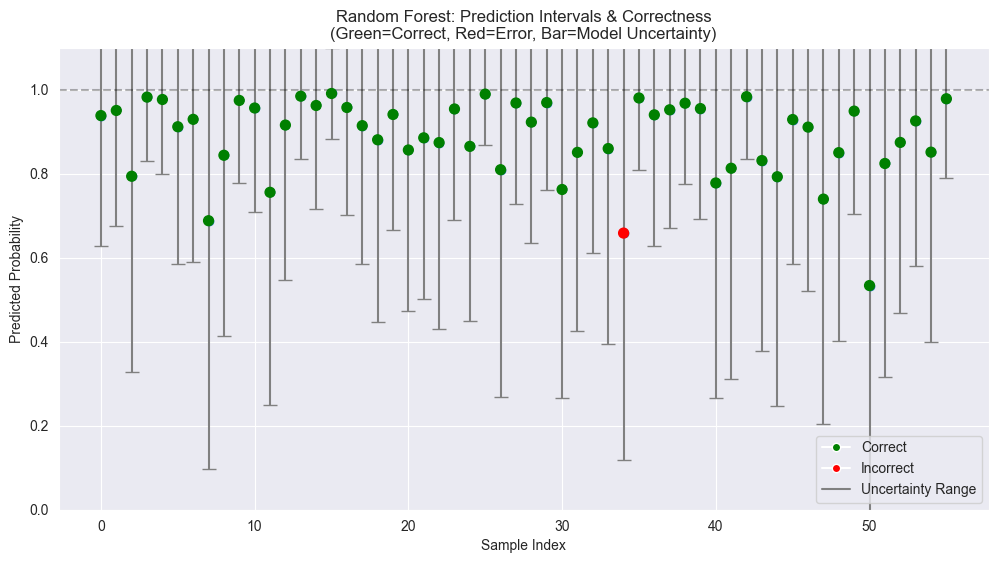

Random Forest analyzed.


In [45]:

# --- 1. RANDOM FOREST (Ensemble) ---
try:
    rf_path = os.path.join(MODELS_DIR_BASE, 'random_forest', 'random_forest.pkl')  # Verify path in your setup
    rf_model = joblib.load(rf_path)

    # Use dedicated method to extract tree-level variance (epistemic uncertainty)
    probs_rf, var_rf = UncertaintyEvaluator.extract_rf_uncertainty(rf_model, X_test)
    std_rf = np.sqrt(var_rf)

    evaluator = UncertaintyEvaluator(y_test, "Random Forest")
    metrics, entropy_rf, _ = evaluator.compute_metrics(probs_rf, epistemic_var=var_rf)
    comparison_table.append(metrics)
    uncertainty_details["Random Forest"] = entropy_rf

    evaluate_uncertainty_utility(y_test, probs_rf, entropy_rf, "Random Forest")
    plot_uncertainty_intervals(y_test, probs_rf, std_rf, "Random Forest")

    print("Random Forest analyzed.")
except FileNotFoundError:
    print("Random Forest model not found.")

In [46]:
# --- 2. XGBOOST (Gradient Boosting) ---
try:
    xgb_path = os.path.join(MODELS_DIR_BASE, 'xgboost', 'XGBoost.pkl')  # Verify path
    xgb_model = joblib.load(xgb_path)

    # XGBoost provides class probabilities directly
    probs_xgb = xgb_model.predict_proba(X_test)

    evaluator = UncertaintyEvaluator(y_test, "XGBoost")
    metrics, entropy_xgb, _ = evaluator.compute_metrics(probs_xgb)
    comparison_table.append(metrics)
    uncertainty_details["XGBoost"] = entropy_xgb

    evaluate_uncertainty_utility(y_test, probs_xgb, entropy_xgb, "Random Forest")

    print("XGBoost analyzed.")
except FileNotFoundError:
    print("XGBoost model not found.")

Random Forest Error Detection AUC: 0.9000
XGBoost analyzed.


XGBoost Ensemble Error Detection AUC: 0.9560


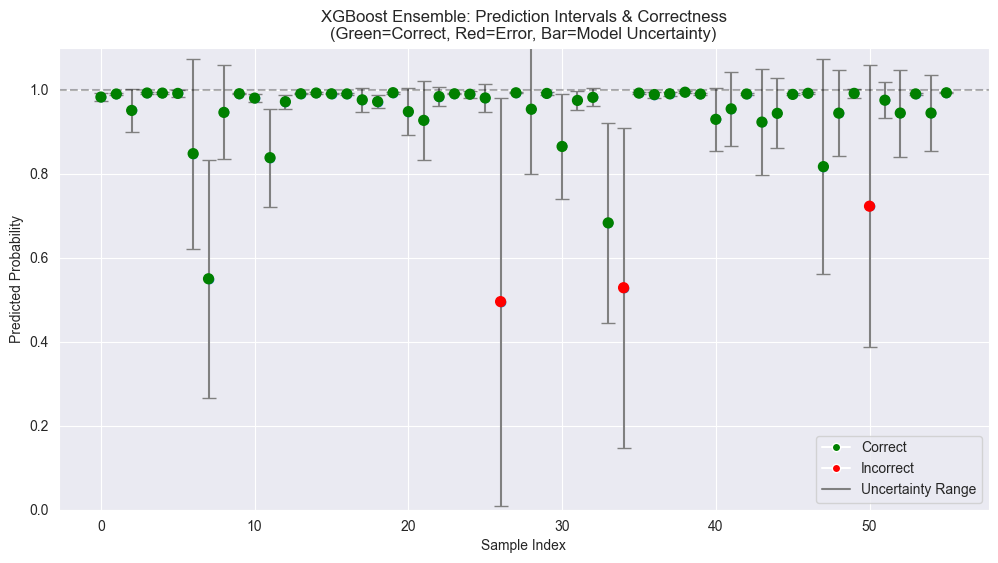

In [47]:
# --- 2. XGBOOST (Bootstrap Ensemble) ---

xgb_ensemble = BootstrapEnsemble(XGBClassifier(eval_metric='mlogloss'), n_estimators=20)
xgb_ensemble.fit(X_train, y_train)

probs_xgb, var_xgb, std_xgb = xgb_ensemble.predict_proba_with_uncertainty(X_test)

evaluator = UncertaintyEvaluator(y_test, "XGBoost Ensemble")
metrics, entropy_xgb, _ = evaluator.compute_metrics(probs_xgb, epistemic_var=var_xgb)
comparison_table.append(metrics)
uncertainty_details["XGBoost Ensemble"] = entropy_xgb

evaluate_uncertainty_utility(y_test, probs_xgb, entropy_xgb, "XGBoost Ensemble")
plot_uncertainty_intervals(y_test, probs_xgb, std_xgb, "XGBoost Ensemble")


In [48]:
# --- 3. GAUSSIAN NAIVE BAYES ---
try:
    gnb_path = os.path.join(MODELS_DIR_BASE, 'naive_bayes', 'gaussian_naive_bayes.pkl')
    gnb_model = joblib.load(gnb_path)

    probs_gnb = gnb_model.predict_proba(X_test)

    evaluator = UncertaintyEvaluator(y_test, "Gaussian NB")
    metrics, entropy_gnb, _ = evaluator.compute_metrics(probs_gnb)
    comparison_table.append(metrics)
    uncertainty_details["Gaussian NB"] = entropy_gnb
    print("GNB analyzed.")
except FileNotFoundError:
    print("GNB model not found.")

GNB analyzed.



=== GNB (Ensemble) Training & Analysis ===
GNB Ensemble Error Detection AUC: 0.8805


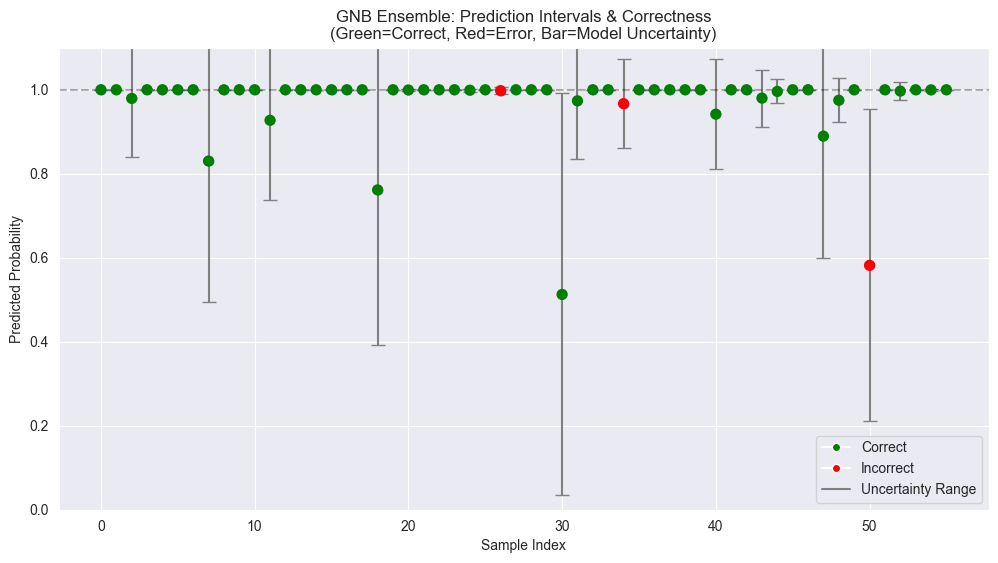

In [49]:
# --- 3. GAUSSIAN NAIVE BAYES (Bootstrap Ensemble) ---
print(f"\n=== GNB (Ensemble) Training & Analysis ===")
gnb_ensemble = BootstrapEnsemble(GaussianNB(), n_estimators=50)
gnb_ensemble.fit(X_train, y_train)

probs_gnb, var_gnb, std_gnb = gnb_ensemble.predict_proba_with_uncertainty(X_test)

evaluator = UncertaintyEvaluator(y_test, "GNB Ensemble")
metrics, entropy_gnb, _ = evaluator.compute_metrics(probs_gnb, epistemic_var=var_gnb)
comparison_table.append(metrics)
uncertainty_details["GNB Ensemble"] = entropy_gnb

evaluate_uncertainty_utility(y_test, probs_gnb, entropy_gnb, "GNB Ensemble")
plot_uncertainty_intervals(y_test, probs_gnb, std_gnb, "GNB Ensemble")

In [50]:
# --- 4. QDA ---
try:
    qda_path = os.path.join(MODELS_DIR_BASE, 'qda', 'qda_model.pkl')
    qda_model = joblib.load(qda_path)

    probs_qda = qda_model.predict_proba(X_test)

    evaluator = UncertaintyEvaluator(y_test, "QDA")
    metrics, entropy_qda, _ = evaluator.compute_metrics(probs_qda)
    comparison_table.append(metrics)
    uncertainty_details["QDA"] = entropy_qda
    print("QDA analyzed.")
except FileNotFoundError:
    print("QDA model not found.")


QDA analyzed.


QDA Ensemble Error Detection AUC: 0.9600


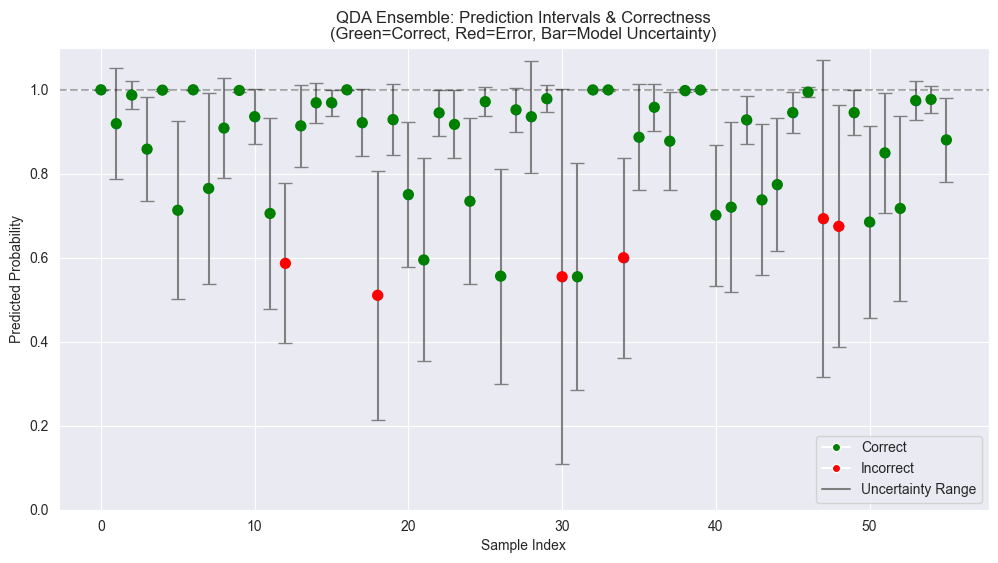

In [51]:
# --- 4. QDA (Bootstrap Ensemble) ---
qda_ensemble = BootstrapEnsemble(QuadraticDiscriminantAnalysis(reg_param=0.5), n_estimators=50)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", message="The covariance matrix")
    qda_ensemble.fit(X_train, y_train)
    probs_qda, var_qda, std_qda = qda_ensemble.predict_proba_with_uncertainty(X_test)

probs_qda, var_qda, std_qda = qda_ensemble.predict_proba_with_uncertainty(X_test)

evaluator = UncertaintyEvaluator(y_test, "QDA Ensemble")
metrics, entropy_qda, _ = evaluator.compute_metrics(probs_qda, epistemic_var=var_qda)
comparison_table.append(metrics)
uncertainty_details["QDA Ensemble"] = entropy_qda

evaluate_uncertainty_utility(y_test, probs_qda, entropy_qda, "QDA Ensemble")
plot_uncertainty_intervals(y_test, probs_qda, std_qda, "QDA Ensemble")

Bayesian Softmax Error Detection AUC: 0.8902


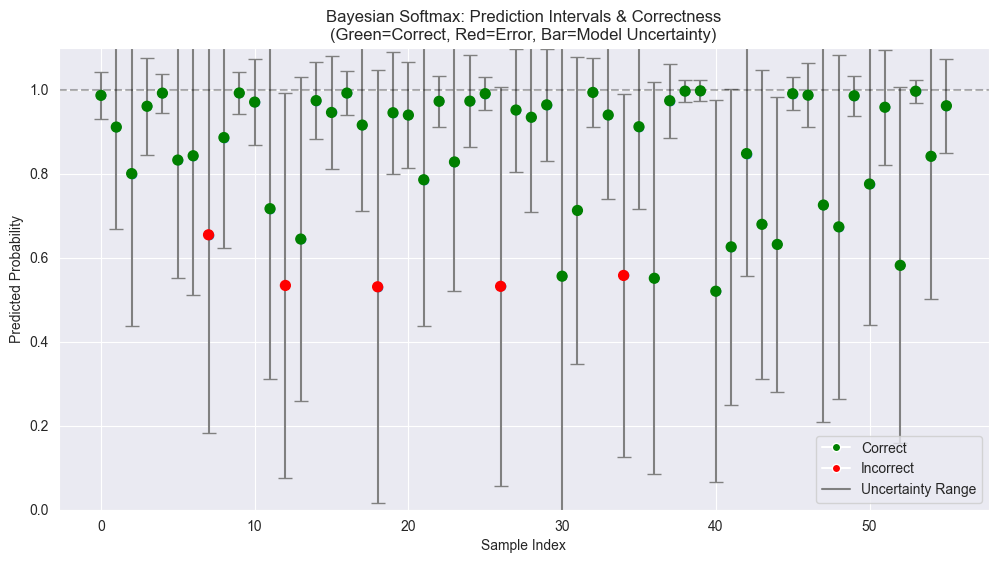

Bayesian model analyzed.


In [52]:
# --- 5. BAYESIAN SOFTMAX (PyMC) ---
try:
    trace_path = os.path.join(MODELS_DIR_BASE, 'bayesian', 'bayesian_trace1.nc')
    scaler_path = os.path.join(MODELS_DIR_BASE, 'bayesian', 'scaler.pkl')
    bayes_map_path = os.path.join(MODELS_DIR_BASE, 'bayesian', 'class_map.pkl')

    trace = az.from_netcdf(trace_path)
    scaler = joblib.load(scaler_path)
    bayes_map = joblib.load(bayes_map_path) # Contains string class names

    X_test_scaled = scaler.transform(X_test)

    probs_bayes, var_bayes = UncertaintyEvaluator.extract_bayesian_uncertainty(trace, X_test_scaled, bayes_map)
    std_bayes = np.sqrt(var_bayes)

    # Correct column order to match LabelEncoder
    bayes_idx_map = {name: i for i, name in enumerate(bayes_map)}
    new_order = [bayes_idx_map[label_name] for label_name in le.classes_]
    probs_bayes_corrected = probs_bayes[:, new_order]

    evaluator = UncertaintyEvaluator(y_test, "Bayesian Softmax")
    metrics, entropy_bayes, _ = evaluator.compute_metrics(probs_bayes_corrected, epistemic_var=var_bayes)

    comparison_table.append(metrics)
    uncertainty_details["Bayesian Softmax"] = entropy_bayes
    evaluate_uncertainty_utility(y_test, probs_bayes_corrected, entropy_bayes, "Bayesian Softmax")
    plot_uncertainty_intervals(y_test, probs_bayes_corrected, std_bayes, "Bayesian Softmax")

    print("Bayesian model analyzed.")

except Exception as e:
    print(f"Bayesian model error: {e}")


=== MODEL RANKING BY UNCERTAINTY QUALITY ===
Best model has LOWEST NLL and ECE, and HIGHEST Accuracy.


,Accuracy,NLL,Brier Score,ECE,Avg Entropy (Total Uncertainty),Avg Epistemic Var
Model,,,,,,
Random Forest,0.982143,0.136118,0.052122,0.105940,0.327659,0.034827
XGBoost,0.982143,0.249463,0.088475,0.175050,0.646908,nan
XGBoost Ensemble,0.946429,0.101196,0.049876,0.060453,0.222405,0.006952
Gaussian NB,0.964286,0.245127,0.079964,0.042609,0.035565,nan
GNB Ensemble,0.946429,0.212453,0.093404,0.041878,0.069191,0.007250
QDA,0.910714,0.235763,0.137325,0.053413,0.335714,nan
QDA Ensemble,0.892857,0.226518,0.133809,0.115453,0.333699,0.012784
Bayesian Softmax,0.910714,0.224982,0.124772,0.086676,0.382682,0.021395


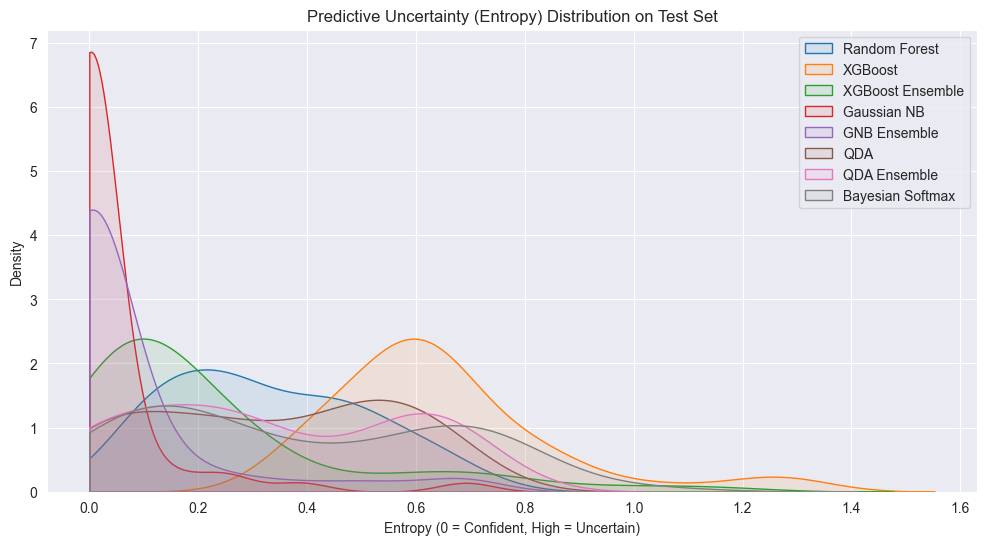


Generating calibration diagram for best-calibrated model: GNB Ensemble


In [53]:
# === SUMMARY AND VISUALIZATION ===

df_results = pd.DataFrame(comparison_table).set_index("Model")

print("\n=== MODEL RANKING BY UNCERTAINTY QUALITY ===")
print("Best model has LOWEST NLL and ECE, and HIGHEST Accuracy.")
display(
    df_results.style
        .background_gradient(cmap='viridis', subset=['Accuracy', 'Avg Epistemic Var'])
        .background_gradient(cmap='viridis_r', subset=['NLL', 'Brier Score', 'ECE'])
)

# Visualization 1: Entropy distribution (model confidence behavior)
plt.figure(figsize=(12, 6))
for name, entropies in uncertainty_details.items():
    sns.kdeplot(entropies, label=name, clip=(0, None), fill=True, alpha=0.1)
plt.title("Predictive Uncertainty (Entropy) Distribution on Test Set")
plt.xlabel("Entropy (0 = Confident, High = Uncertain)")
plt.legend()
plt.show()

# Visualization 2: Reliability Diagram (Calibration) for the best-calibrated model
# Select model with the lowest ECE
best_model_name = df_results['ECE'].idxmin()
print(f"\nGenerating calibration diagram for best-calibrated model: {best_model_name}")

